# Visualise targets for simulation

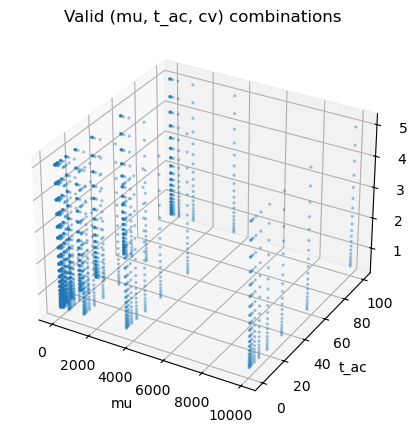

In [10]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
# Load the full grid of verified targets
mu_target = np.logspace(0, 4, 10)  # 1 to 10000
t_ac_target = np.logspace(-0.3, 2, 10)  # ~0.5 to 100
cv_target = np.logspace(-0.3, 0.7, 20)  # ~0.5 to 5
targets = np.array(np.meshgrid(mu_target, t_ac_target, cv_target)).T.reshape(-1, 3)

# Create a 3D scatter plot of mu vs t_ac vs cv
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(targets[:, 0], targets[:, 1], targets[:, 2], s=2, alpha=0.3)
ax.set_xlabel('mu')
ax.set_ylabel('t_ac')
ax.set_zlabel('cv')
ax.set_title('Valid (mu, t_ac, cv) combinations')
plt.show()


CV values range from 0.50 to 5.01.


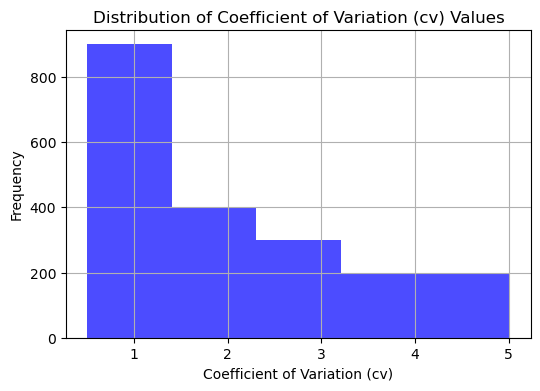

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
df_targets = pd.DataFrame(targets, columns=['mu', 't_ac', 'cv'])
# what ranges of CV values are chosen? 
cv_min = df_targets['cv'].min()
cv_max = df_targets['cv'].max()
print(f"CV values range from {cv_min:.2f} to {cv_max:.2f}.")
# plot the distribution of cv values chosen
plt.figure(figsize=(6, 4))
plt.hist(df_targets['cv'], bins=5, color='blue', alpha=0.7)
plt.xlabel('Coefficient of Variation (cv)')
plt.ylabel('Frequency')
plt.title('Distribution of Coefficient of Variation (cv) Values')
plt.grid()  
plt.show()

mu values range from 1.00 to 10000.00.


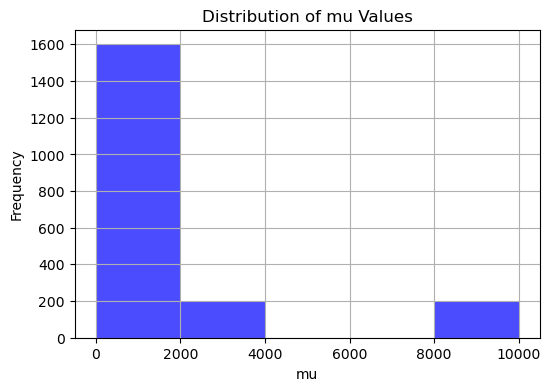

In [12]:
mu_min = df_targets['mu'].min()
mu_max = df_targets['mu'].max()
print(f"mu values range from {mu_min:.2f} to {mu_max:.2f}.")
# plot the distribution 
plt.figure(figsize=(6, 4))
plt.hist(df_targets['mu'], bins=5, color='blue', alpha=0.7)
plt.xlabel('mu')
plt.ylabel('Frequency')
plt.title('Distribution of mu Values')
plt.grid()  
plt.show()

t_ac values range from 0.50 to 100.00.


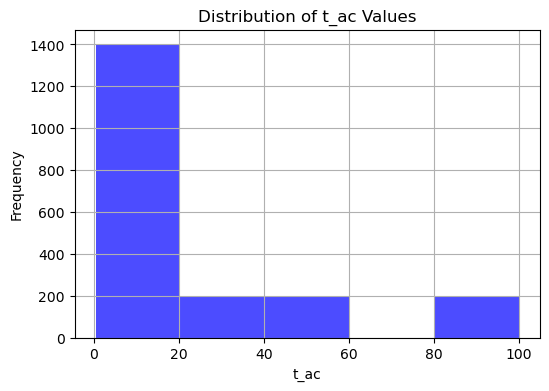

In [13]:
t_ac_min = df_targets['t_ac'].min()
t_ac_max = df_targets['t_ac'].max()
print(f"t_ac values range from {t_ac_min:.2f} to {t_ac_max:.2f}.")
# plot the distribution 
plt.figure(figsize=(6, 4))
plt.hist(df_targets['t_ac'], bins=5, color='blue', alpha=0.7)
plt.xlabel('t_ac')
plt.ylabel('Frequency')
plt.title('Distribution of t_ac Values')
plt.grid()  
plt.show()